In [1]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from sklearn import linear_model
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
def word_count(txt):
    distinguish_word = ""
    totel_count = 0
    distinguish_count = 0
    for word in txt:
        totel_count = totel_count + 1
        if word not in distinguish_word:
            distinguish_word = distinguish_word + ' ' + word
            distinguish_count = distinguish_count +1
    return totel_count

In [3]:
def diff_word_count(txt):
    distinguish_word = ""
    totel_count = 0
    distinguish_count = 0
    for word in txt:
        totel_count = totel_count + 1
        if word not in distinguish_word:
            distinguish_word = distinguish_word + ' ' + word
            distinguish_count = distinguish_count +1
    return distinguish_count

# I - Loading data

## 1 - Get categories of text

In [4]:
dir_path = os.path.join(os.getcwd(), 'vnexpress')
categories = list()

data = list()
for directory in os.listdir(dir_path):
#     print(directory)
    if '.' not in directory:
        list_file_path = os.path.join(dir_path, directory)
        count = 0
        for file_name in os.listdir(list_file_path):
            data_dict = dict()
            data_dict['file_name'] = file_name
            data_dict['category'] = directory
            file_path = os.path.join(list_file_path, file_name)
            file = open(file_path,'r')
            data_dict['data'] = file.read()
            data.append(data_dict)

In [5]:
data_df = pd.DataFrame(data)
data_df['distinguish_word'] = data_df.data.apply(lambda row:diff_word_count(row))
data_df['total_count'] = data_df.data.apply(lambda row:word_count(row))

## sample 10000 items to training and testing

In [6]:
# sample_df = data_df.sample(10000)
sample_df = data_df
train, test = train_test_split(sample_df, test_size = 0.3)

In [7]:
training_data = train.data
training_label = train.category
testing_data = test.data
testing_label = test.category

In [8]:
len(training_data)

33240

## Fitting tf-idf model

In [9]:
t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5)
vectorizer.fit(training_data)
print("tf-idf learning time:", time() - t0)

tf-idf learning time: 10.34434199333191


In [10]:
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

## Extracting features for training and testing data

In [11]:
t0 = time()
training_matrix = vectorizer.transform(training_data)
testing_matrix = vectorizer.transform(testing_data)
print("feature extraction time of training and testing dataset:", time() - t0)

feature extraction time of training and testing dataset: 17.334089040756226


In [12]:
print('training',training_matrix.shape)
print('testing',testing_matrix.shape)

training (33240, 137287)
testing (14247, 137287)


## Classification by Logistic Regression of Scikit Learn

In [13]:
t0 = time()
logreg = linear_model.LogisticRegression(solver = 'sag',C=1e5)
logreg.fit(training_matrix,training_label)
print('Logistic Regression time:',time()-t0)

/Users/vunguyen/anaconda/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Logistic Regression time: 115.61367607116699


In [14]:
t0 = time()
predicted_result = logreg.predict(testing_matrix)
print("testing time:", time()-t0)

testing time: 0.0807960033416748


In [15]:
test['predicted'] = predicted_result

/Users/vunguyen/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [16]:
def check_result(actual,predict):
    return predict==actual

In [17]:
test['eval'] = test.apply(lambda row:check_result(row['category'],row['predicted']),axis=1)

/Users/vunguyen/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [18]:
result = test.loc[test['eval']==False]

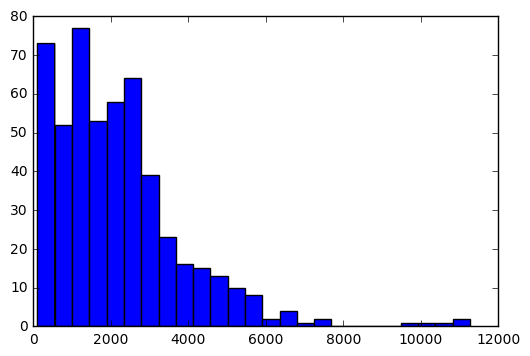

In [19]:
import matplotlib.pyplot as plt
plt.hist(result['total_count'], bins ='auto')  # plt.hist passes it's arguments to np.histogram
plt.show()

In [18]:
from sklearn import svm,metrics,model_selection
print(metrics.classification_report(testing_label, predicted_result))

             precision    recall  f1-score   support

     dulich       0.95      0.96      0.96      1164
    giaitri       0.98      0.99      0.98      1335
    giaoduc       0.95      0.96      0.96      1312
    khoahoc       0.96      0.95      0.95      1350
  kinhdoanh       0.94      0.95      0.95      1353
   otoxemay       0.99      0.98      0.99      1290
   phapluat       0.96      0.95      0.96      1347
      sohoa       0.97      0.96      0.97      1225
    thegioi       0.96      0.97      0.96      1325
    thethao       1.00      0.99      0.99      1319
     thoisu       0.92      0.91      0.92      1227

avg / total       0.96      0.96      0.96     14247



In [21]:
df_confusion = pd.crosstab(testing_label, predicted_result, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,dulich,giaitri,giaoduc,khoahoc,kinhdoanh,otoxemay,phapluat,sohoa,thegioi,thethao,thoisu,All
Actual,,,,,,,,,,,,
dulich,1110,5,8,9,3,2,1,1,6,0,16,1161
giaitri,3,1352,3,0,0,0,1,0,2,0,3,1364
giaoduc,4,1,1215,7,6,0,4,11,4,2,11,1265
khoahoc,7,1,10,1227,4,2,2,2,18,0,7,1280
kinhdoanh,12,3,7,1,1321,2,7,9,1,1,38,1402
otoxemay,4,0,2,4,1,1251,5,1,0,1,0,1269
phapluat,3,1,5,1,5,5,1292,1,1,0,32,1346
sohoa,5,7,6,10,10,1,0,1152,5,1,0,1197
thegioi,11,6,5,16,5,3,0,4,1300,1,3,1354


### Tuning C 

In [22]:
from sklearn.model_selection import GridSearchCV
parameters = {'C':[1e6,1e5, 1e4,1e3,1e2]}
logreg = linear_model.LogisticRegression()
grid_search = GridSearchCV(logreg,parameters)
grid_search.fit(training_matrix, training_label)
paras = grid_search.best_params_
print(paras)

{'C': 1000.0}


In [23]:
t0 = time()
logreg = linear_model.LogisticRegression(C=1)
logreg.fit(training_matrix,training_label)
predicted_result = logreg.predict(testing_matrix)
print(metrics.classification_report(testing_label, predicted_result))
print('Logistic Regression time:',time()-t0)

             precision    recall  f1-score   support

     dulich       0.93      0.93      0.93      1161
    giaitri       0.97      0.99      0.98      1364
    giaoduc       0.94      0.95      0.95      1265
    khoahoc       0.94      0.95      0.94      1280
  kinhdoanh       0.93      0.92      0.92      1402
   otoxemay       0.97      0.98      0.97      1269
   phapluat       0.95      0.95      0.95      1346
      sohoa       0.96      0.94      0.95      1197
    thegioi       0.95      0.94      0.94      1354
    thethao       0.99      0.99      0.99      1388
     thoisu       0.89      0.90      0.90      1221

avg / total       0.95      0.95      0.95     14247

Logistic Regression time: 14.894895076751709


In [ ]:
df_confusion = pd.crosstab(testing_label, predicted_result, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,dulich,giaitri,giaoduc,khoahoc,kinhdoanh,otoxemay,phapluat,sohoa,thegioi,thethao,thoisu,All
Actual,,,,,,,,,,,,
dulich,1084,8,13,17,7,3,4,1,9,1,14,1161
giaitri,3,1345,4,1,2,0,1,0,4,1,3,1364
giaoduc,4,2,1201,15,7,0,4,10,6,3,13,1265
khoahoc,8,2,7,1219,8,8,1,3,16,0,8,1280
kinhdoanh,14,4,4,2,1286,4,9,21,4,2,52,1402
otoxemay,3,0,4,3,7,1239,6,1,3,2,1,1269
phapluat,3,0,10,1,9,11,1273,1,1,0,37,1346
sohoa,6,9,11,12,21,1,0,1120,12,4,1,1197
thegioi,12,10,7,23,11,5,6,5,1267,4,4,1354


## Dimensionality reduction classification

## Dimensionality Reduction

In [ ]:
from sklearn import (manifold, datasets, decomposition, ensemble,discriminant_analysis, random_projection)
reducer = decomposition.TruncatedSVD(n_components = 10000)
reducer.fit(training_matrix)

In [ ]:
training_vector_reduce = reducer.transform(training_matrix)
testing_vector_reduce = reducer.transform(testing_matrix)

In [ ]:
t0 = time()
logreg = linear_model.LogisticRegression(C=10000)
logreg.fit(training_vector_reduce,training_label)
print('Logistic Regression time:',time()-t0)

In [ ]:
t0 = time()
predicted_result = logreg.predict(testing_vector_reduce)
print("testing time:", time()-t0)
print(metrics.classification_report(testing_label, predicted_result))